In [2]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above. 
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)

OS information
Linux-5.4.0-70-generic-x86_64-with-debian-buster-sid

Is GPU available?
True

GPU information
Thu Mar 25 20:36:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:67:00.0 Off |                  N/A |
| 30%   26C    P8    10W / 350W |      8MiB / 24268MiB |      0%      Default |
|                               |              

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [6]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [7]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [8]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

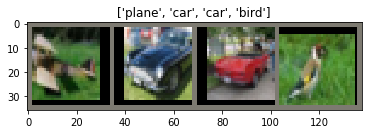

In [11]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### VGG16 Architecture 

In [26]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
    
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
                            nn.BatchNorm2d(64), 
                            nn.ReLU(),
                             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(64),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2),
                                 
                             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(128),
                            nn.ReLU(),
                             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                              
                             nn.MaxPool2d(kernel_size=2),    
                                 
                             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(256),
                            nn.ReLU(),
                             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(256),
                            nn.ReLU(),
                             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(256),
                            nn.ReLU(),

                             nn.MaxPool2d(kernel_size=2),    
                                 
                            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),

                             nn.MaxPool2d(kernel_size=2),    
                                 
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(512),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(512),
                            nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
                             nn.BatchNorm2d(512),
                            nn.ReLU(),

                             nn.MaxPool2d(kernel_size=2)     
                             )
        self.fc = nn.Sequential(nn.Linear(512,3))
        
    def forward(self,x):
        out = self.cnn(x)
        # New out size: (128, 512*1*1)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc(out)

        return out        

STEP 3: CREATE MODEL CLASS (VGG16)


In [27]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14724675


VGG(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [61]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### Train the VGG 16 model and print test accuracy for every epochs

In [29]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

iter=0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device) 
                # Forward pass only to get logits/output
                outputs = model(images)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Epoch: {}. Iteration: {}. Loss: {}. Accuracy: {}'.format(epoch, iter, loss.item(), accuracy))



STEP 7: TRAIN THE MODEL
Epoch: 0. Iteration: 100. Loss: 0.5647364258766174. Accuracy: 78.6
Epoch: 1. Iteration: 200. Loss: 0.5016461610794067. Accuracy: 84.5
Epoch: 2. Iteration: 300. Loss: 0.2882249355316162. Accuracy: 86.4
Epoch: 3. Iteration: 400. Loss: 0.264885812997818. Accuracy: 86.7
Epoch: 4. Iteration: 500. Loss: 0.13692866265773773. Accuracy: 90.43333333333334
Epoch: 5. Iteration: 600. Loss: 0.21354438364505768. Accuracy: 89.26666666666667
Epoch: 5. Iteration: 700. Loss: 0.1175544261932373. Accuracy: 90.46666666666667
Epoch: 6. Iteration: 800. Loss: 0.2249738872051239. Accuracy: 90.0
Epoch: 7. Iteration: 900. Loss: 0.08939456939697266. Accuracy: 90.13333333333334
Epoch: 8. Iteration: 1000. Loss: 0.12059716135263443. Accuracy: 90.36666666666666
Epoch: 9. Iteration: 1100. Loss: 0.1038648933172226. Accuracy: 90.63333333333334
Epoch: 10. Iteration: 1200. Loss: 0.03491270914673805. Accuracy: 92.1
Epoch: 11. Iteration: 1300. Loss: 0.05879099294543266. Accuracy: 91.43333333333334
Epo

## ResNet

### Residual block

In [302]:
def layer(inp,out,ker,stride=1,pad=1,opt=0):
    if opt==1:
        layer = nn.Sequential(nn.Conv2d(inp, out, kernel_size=ker, stride=stride, padding=pad),
                         nn.BatchNorm2d(out))
    else:
        layer = nn.Sequential(nn.Conv2d(inp, out, kernel_size=ker, stride=stride, padding=pad),
                         nn.BatchNorm2d(out),
                         nn.ReLU())
    return layer

In [304]:
def conv1():
    conv1 = nn.Sequential(layer(3,64,3,pad=1))
    return conv1   

In [305]:
def conv2():
    conv2 = nn.Sequential(layer(256,64,1,pad=0),layer(64,64,3),layer(64,256,1,pad=0,opt=1))
    return conv2

In [306]:
def conv3(stride=1):
    conv3 = nn.Sequential(layer(512,128,1,stride=stride,pad=0),layer(128,128,3),layer(128,512,1,pad=0,opt=1))
    return conv3

In [307]:
def conv4(stride=1):
    conv4 = nn.Sequential(layer(1024,256,1,pad=0),layer(256,256,3),layer(256,1024,1,pad=0,opt=1))
    return conv4

In [308]:
def conv5(stride=1):
    conv5 = nn.Sequential(layer(2048,512,1,pad=0),layer(512,512,3),layer(512,2048,1,pad=0,opt=1))
    return conv5

In [309]:
class Block2(nn.Module):
    def __init__(self,case=0):
        super(Block2,self).__init__()
        self.cnn = conv2()
        self.shortcut = nn.Sequential()
        if case==1:
            self.cnn[0] = layer(64,64,1,pad=0)
            self.shortcut = nn.Sequential(
            layer(64,256,1,pad=0,opt=1)
            )
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.cnn(x) + self.shortcut(x)
        out = self.relu(out)
        return out

In [310]:
class Block3(nn.Module):
    def __init__(self,case=0):
        super(Block3,self).__init__()
        self.cnn = conv3()
        self.shortcut = nn.Sequential()
        if case==1:
            self.cnn[0] = layer(256,128,1,pad=0,stride=2)
            self.shortcut = nn.Sequential(
            layer(256,512,1,pad=0,opt=1,stride=2))
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.cnn(x) + self.shortcut(x)
        out = self.relu(out)
        return out

In [311]:
class Block4(nn.Module):
    def __init__(self,case=0):
        super(Block4,self).__init__()
        self.cnn = conv4()
        self.shortcut = nn.Sequential()
        if case==1:
            self.cnn[0] = layer(512,256,1,pad=0,stride=2)
            self.shortcut = nn.Sequential(
            layer(512,1024,1,opt=1,pad=0,stride=2))
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.cnn(x) + self.shortcut(x)
        out = self.relu(out)
        return out

In [312]:
class Block5(nn.Module):
    def __init__(self,case=0):
        super(Block5,self).__init__()
        self.cnn = conv5()
        self.shortcut = nn.Sequential()
        if case==1:
            self.cnn[0] = layer(1024,512,1,pad=0,stride=2)
            self.shortcut = nn.Sequential(
            layer(1024,2048,1,opt=1,pad=0,stride=2))
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.cnn(x) + self.shortcut(x)
        out = self.relu(out)
        return out

### ResNet architecture

In [313]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.cnn = nn.Sequential(
        conv1(),
        Block2(1),Block2(),Block2(),
        Block3(1),Block3(),Block3(),Block3(),
        Block4(1),Block4(),Block4(),Block4(),Block4(),Block4(),
        Block5(1),Block5(),Block5(),
        nn.AvgPool2d(4))
        self.fc = nn.Sequential(nn.Linear(2048,3))
        
        
    def forward(self,x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)        
        return out

    
print('STEP 4: INSTANTIATE MODEL CLASS')
model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23533059


ResNet(
  (cnn): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Block2(
      (cnn): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (shortcut): Sequent

### 2.2 Print test accuracy for every epochs

In [314]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)


print('STEP 7: TRAIN THE MODEL')
num_epochs = 15
iter=0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device) 
                # Forward pass only to get logits/output
                outputs = model(images)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Epoch: {}. Iteration: {}. Loss: {}. Accuracy: {}'.format(epoch, iter, loss.item(), accuracy))


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epoch: 0. Iteration: 100. Loss: 0.6061371564865112. Accuracy: 75.76666666666667
Epoch: 1. Iteration: 200. Loss: 0.5213652849197388. Accuracy: 78.53333333333333
Epoch: 2. Iteration: 300. Loss: 0.42608359456062317. Accuracy: 79.73333333333333
Epoch: 3. Iteration: 400. Loss: 0.48162904381752014. Accuracy: 83.4
Epoch: 4. Iteration: 500. Loss: 0.3004254996776581. Accuracy: 82.23333333333333
Epoch: 5. Iteration: 600. Loss: 0.497819721698761. Accuracy: 82.13333333333334
Epoch: 5. Iteration: 700. Loss: 0.4714495837688446. Accuracy: 81.9
Epoch: 6. Iteration: 800. Loss: 0.22626987099647522. Accuracy: 83.7
Epoch: 7. Iteration: 900. Loss: 0.12189944833517075. Accuracy: 85.1
Epoch: 8. Iteration: 1000. Loss: 0.2699798047542572. Accuracy: 83.33333333333333
Epoch: 9. Iteration: 1100. Loss: 0.13810893893241882. Accuracy: 84.93333333333334
Epoch: 10. Iteration: 1200. Loss: 0.07873599231243134. Accuracy: 86.2333333